In [ ]:
#default_exp core.clvae

In [ ]:
#export
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from cmaes import CMA
import os
import numpy as np
import copy

from vase.core.models import FCEncoder, FCDecoder, Encoder, Decoder, EnvironmentInference
from vase.core.utils import rec_likelihood, disable_gradient, kl_div_stdnorm, euclidean, show_batch
from vase.config import DATA_PATH, LOG_PATH

In [ ]:
#hide
from vase.core.datasets.moving_mnist import CommonMNIST, CommonFashionMNIST, MovingMNIST, MovingFashionMNIST, FixedMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
batch_size = 64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

# Continually Learning Variational Autoencoder
> Performs unsupervised continual representation learning with generative replay and environment likelihood detection

Notes: assumes sequential tasks - "local stationarity" i.e. will stay on distribution long enough to learn it

In [ ]:
#export
class CLVAE(nn.Module):
    def __init__(self, 
        encoder_type: type,
        decoder_type: type,
        final_size: int, 
        latents: int,
        max_envs: int,
        atyp_min: float,
        atyp_max: float,
        env_optim: type,
        env_lr: float,
        env_epochs: int,
        replay_batch_size: int,
        device: str,
    ):
        super().__init__()
        self.latents = latents
        self.max_envs = max_envs
        self.final_size = final_size
        self.atyp_min = atyp_min
        self.atyp_max = atyp_max
        self.device = device
        self.encoder = encoder_type(self.latents, device=self.device)
        self.decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.old_encoder = encoder_type(self.latents, device=self.device)
        self.old_decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.copy_and_freeze()
        self.encoder.to(self.device), self.decoder.to(self.device), self.old_encoder.to(self.device), self.old_decoder.to(self.device)
        self.replay_batch_size = replay_batch_size
        self.env_net = EnvironmentInference(self.max_envs, self.final_size)
        self.env_net.to(self.device)
        self.env_optim = env_optim(params=self.env_net.parameters(), lr=env_lr)
        self.env_loss = nn.CrossEntropyLoss()
        self.env_epochs = env_epochs
       
        self.m = -1
        self.steps = 0
        self.learning = False

    def forward(self, x):
        batch_size = x.shape[0]
        self.steps += 1

        x_halu, s_halu = self.sample_old()
        
        mu, logvar, final = self.encoder(x)

        if not self.training:
            z = mu 
            s = torch.argmax(self.env_net(final)[0:self.m+1])
            rec_x = self.decoder(z, self.int_to_vec(s, batch_size))
            atyp = self.get_atyp(z)
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
            rec_x_halo = self.decoder(mu_halu, s_halu)
            return rec_x, mu, logvar, x_halu, rec_x_halo, mu_halu_old, mu_halu, s_halu, atyp
        
        s = self.m if self.m != -1 else 0
        z = self.reparam(mu, logvar)
        rec_x = self.decoder(z, self.int_to_vec(s, batch_size))

        atyp = self.get_atyp(z)

        if self.m == -1:
            if atyp > self.atyp_max:
                self.m = 0
                self.learning = True
        
        elif self.learning:
            if atyp < self.atyp_min:
                self.learning = False
        
        elif atyp > self.atyp_max:
            self.learning = True
            self.m += 1
            if self.m > self.max_envs:
                print("Warning: too many environments")
            self.copy_and_freeze()
        
        
        with torch.no_grad():
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            z_halu_old = self.reparam(mu_halu_old, logvar_halu_old)
        
        mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
        z_halu = self.reparam(mu_halu, logvar_halu)
        rec_x_halo = self.decoder(z_halu, s_halu)

        if self.training:
            self.train_env_network(final, s, final_halu_old, s_halu)

        return rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp

    def get_likely_env(self, final):
        env_logits = self.env_net(final)
        avg_env_logits = torch.mean(env_logits, dim=0)
        valid_logits = avg_env_logits[0:self.m+1]
        return torch.argmax(valid_logits), env_logits
    
    def get_atyp(self, z):
        with torch.no_grad():
            std, mean = torch.std_mean(z, dim=0)
            std = std[:,None]
            mean = mean[:, None]
            logvar = torch.log(std.pow(2))
            atyps = kl_div_stdnorm(mean, logvar)
        return torch.sum(atyps)
    
    def reparam(self, mu, logvar):
        eps = torch.randn(logvar.shape).to(self.device)
        std = (0.5 * logvar).exp()
        return mu + std * eps
    
    def int_to_vec(self, i, size):
        return torch.ones([size], dtype=torch.int64).to(self.device) * i
    
    def copy_model(self, old_model, cur_model):
        old_model.load_state_dict(cur_model.state_dict())
    
    def freeze_model(self, model):
        disable_gradient(model)
    
    def copy_and_freeze(self):
        self.copy_model(self.old_encoder, self.encoder)
        self.freeze_model(self.old_encoder)
        self.copy_model(self.old_decoder, self.decoder)
        self.freeze_model(self.old_decoder)
    
    def train_env_network(self, final, s, final_halu_old, s_halu):
        env_logits = self.env_net(final)
        final_halu_old = final_halu_old[s != s_halu]
        s_halu = s_halu[s != s_halu]
        self.env_optim.zero_grad()
        cur_loss = self.env_loss(env_logits, self.int_to_vec(s, env_logits.shape[0])) #don't know if dims work here
        if len(s_halu) > 0:
            env_logits_halu = self.env_net(final_halu_old)
            replay_loss = self.env_loss(env_logits_halu, s_halu)
        else: 
            replay_loss = 0
        loss = cur_loss + replay_loss
        loss.backward(retain_graph=True)
        self.env_optim.step()
    
    def sample_old(self):
        max_env = self.m+1 if self.m != -1 else 1
        s = torch.randint(0, max_env, (self.replay_batch_size,)).to(self.device)
        z = torch.randn([self.replay_batch_size, self.latents]).to(self.device)
        with torch.no_grad():
            halu_x = self.old_decoder(z, s)
        return halu_x, s

In [ ]:
def train(model, loader, epochs, alpha, beta, optimizer, writer):
    for epoch in range(epochs):
        total_loss = 0
        total_rec_loss = 0
        total_div_loss = 0
        for contents in loader:
            X = contents[0]
            X = X.to(device)
            optimizer.zero_grad()

            rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp = model(X)

            rec_loss = torch.mean(rec_likelihood(X, rec_x))
            kl_loss = gamma * torch.mean(torch.square(kl_div_stdnorm(mu, logvar))) #NOTE: should I square this?
            mdl_loss = rec_loss + kl_loss

            e_prox_loss = alpha * torch.mean(euclidean(z_halu, z_halu_old))
            d_prox_loss = beta * torch.mean(rec_likelihood(x_halu, rec_x_halo)) #NOTE: not sure if this order is correct
            dream_loss = e_prox_loss + d_prox_loss

            loss = mdl_loss + dream_loss

            loss.backward(retain_graph=True)
            optimizer.step()

            writer.add_scalar("train/loss", loss, model.steps)
            writer.add_scalar("train/rec_loss", rec_loss, model.steps)
            writer.add_scalar("train/kl_loss", kl_loss, model.steps)
            writer.add_scalar("train/e_prox_loss", e_prox_loss, model.steps)
            writer.add_scalar("train/d_prox_loss", d_prox_loss, model.steps)
            writer.add_scalar("train/num_envs", model.m+1, model.steps)
            writer.add_scalar("train/atypicality", atyp, model.steps)
            total_loss += loss
            total_rec_loss += rec_loss
            total_div_loss += kl_loss
        print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

In [ ]:
encoder_type = FCEncoder
decoder_type = FCDecoder
final_size = 50
latents = 8
max_envs = 7
atyp_min = 0.1
atyp_max = 0.5
env_optim = torch.optim.Adam
env_lr = 6e-4
env_epochs = 10
replay_batch_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

clvae_fc = CLVAE(encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, device)

epochs=10
lr=6e-4
gamma=20
alpha=1
beta=10
optimizer = torch.optim.Adam(params=clvae_fc.parameters(), lr=lr)
name = "clvae_fc" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
writer = SummaryWriter(os.path.join(LOG_PATH, name))

In [ ]:
train(clvae_fc, sf_loader, epochs, alpha, beta, optimizer, writer)

epoch: 0, loss=85081.7578125, rec_loss=5564.06298828125, total_div_loss=132.3538360595703
epoch: 1, loss=84517.015625, rec_loss=4965.68359375, total_div_loss=235.47108459472656
epoch: 2, loss=84405.8984375, rec_loss=4869.92529296875, total_div_loss=274.213134765625
epoch: 3, loss=84351.8203125, rec_loss=4822.34716796875, total_div_loss=295.724609375
epoch: 4, loss=84298.7890625, rec_loss=4803.65380859375, total_div_loss=302.4810485839844
epoch: 5, loss=84281.6015625, rec_loss=4797.052734375, total_div_loss=308.38555908203125
epoch: 6, loss=84266.578125, rec_loss=4784.640625, total_div_loss=310.1473693847656
epoch: 7, loss=84262.28125, rec_loss=4783.42919921875, total_div_loss=313.22161865234375
epoch: 8, loss=84254.3671875, rec_loss=4780.248046875, total_div_loss=313.91534423828125
epoch: 9, loss=84242.8984375, rec_loss=4776.6435546875, total_div_loss=314.69635009765625


In [ ]:
train(clvae_fc, mnist_loader, epochs, alpha, beta, optimizer, writer)

epoch: 0, loss=54442.25, rec_loss=3143.255615234375, total_div_loss=120.06339263916016
epoch: 1, loss=54088.3984375, rec_loss=2974.41064453125, total_div_loss=56.440982818603516
epoch: 2, loss=53963.12109375, rec_loss=2953.149169921875, total_div_loss=53.42716979980469
epoch: 3, loss=53991.234375, rec_loss=2942.515380859375, total_div_loss=54.44313430786133
epoch: 4, loss=53885.85546875, rec_loss=2937.07421875, total_div_loss=54.84893035888672
epoch: 5, loss=53897.4375, rec_loss=2929.983642578125, total_div_loss=55.367496490478516
epoch: 6, loss=53983.92578125, rec_loss=2926.376708984375, total_div_loss=55.806209564208984
epoch: 7, loss=53902.58984375, rec_loss=2922.50341796875, total_div_loss=56.12763595581055
epoch: 8, loss=53881.31640625, rec_loss=2919.3466796875, total_div_loss=56.87919235229492
epoch: 9, loss=53870.265625, rec_loss=2916.83984375, total_div_loss=58.0069465637207


In [ ]:
clvae_fc.eval()

CLVAE(
  (encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): FCDecoder(
    (linear1): Linear(in_features=15, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (old_encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=8, bias=True)
    (act): ReLU()
  )
  (old_decoder): FCDecoder(
    (linear1): Linear(in_features=15, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (env_net): EnvironmentInference(
    (linear): Linear(in_features=50, o

In [ ]:
with torch.no_grad():
    results = clvae_fc(mnist_batch)
rec_img = results[0]

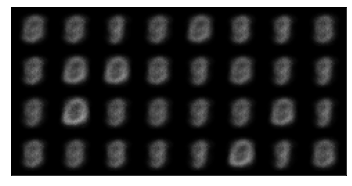

In [ ]:
show_batch(rec_img[0:32])